In [1]:

import numpy as np
import matplotlib.pyplot as plt
from time import time as ti
from matplotlib import cm
from tqdm import tqdm
from numba import cuda
# import nvtx
import cupy as cp
import numba as nb

/home/cisco581b/.local/lib/python3.8/site-packages/cupy/_environment.py:447: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:

@cuda.jit
def macroscopic(rho, u, fin, nx, ny, v):
    i, j = cuda.grid(2)
    
    if i < nx and j < ny:
        rho[i, j] = 0.0
        u[i, j, 0] = 0.0
        u[i, j, 1] = 0.0
        for k in range(9):
            rho[i, j] += fin[k, i, j]
            u[i, j, 0] += fin[k, i, j] * v[k, 0]
            u[i, j, 1] += fin[k, i, j] * v[k, 1]
        u[i, j, 0] /= rho[i, j]
        u[i, j, 1] /= rho[i, j]

In [3]:
@cuda.jit
def equilibrium(feq, rho, u, v, t):
    nx, ny, _ = u.shape
    i, j = cuda.grid(2)
    
    if i < nx and j < ny:
        usqr = (3/2)*(u[i, j, 0]**2 + u[i, j, 1]**2)
        for k in range(9):
            cu = 3*(v[k, 0]*u[i, j, 0] + v[k, 1]*u[i, j, 1])
            feq[k, i, j] = rho*t[k]*(1 + cu + 0.5*cu**2 - usqr)

In [4]:
def obstacle_fun(cx, cy, r):
    def inner(x, y):
        return (x-cx)**2+(y-cy)**2<r**2
    return inner


In [5]:
def inivel(uLB, ly, d, nx, ny):
    yy = cp.linspace(0, ny - 1, ny).repeat(nx).reshape((ny, nx))
    yy = yy.T
    vel = cp.zeros((d, nx, ny))
    for dir in range(d):
        vel[dir,:,:] = (1-dir) * uLB * (1 + 1e-4 * cp.sin(yy / ly * 2 * cp.pi))
    return vel

In [6]:
Re = 50.0
maxIter = 30000
nx, ny = 720, 340
ly = ny-1
uLB = 0.04
cx, cy, r = nx//4, ny//2, ny/9
nulb = uLB*r/Re
omega = 1 / (3*nulb+0.5)

v = cp.array([
            [1,1],
            [1,0],
            [1,-1],
            [0,1],
            [0,0],
            [0,-1],
            [-1,1],
            [-1,0],
            [-1,-1]
            ])

t = cp.array([
            1/36,
            1/9,
            1/36,
            1/9,
            4/9,
            1/9,
            1/36,
            1/9,
            1/36
            ])

col_0 = cp.array([0,1,2])
col_1 = cp.array([3,4,5])
col_2 = cp.array([6,7,8])

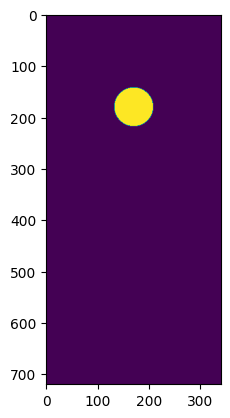

In [7]:
obstacle = cp.array(cp.fromfunction(obstacle_fun(cx,cy,r),(nx, ny)))
ob = obstacle.get()
if True:
  plt.imshow(ob)

In [8]:
# def compute_rho(fin_col_1, fin_col_2, u_0):
#     return 1 / (1 - u_0) * (cp.sum(fin_col_1, axis=0) + 2 * cp.sum(fin_col_2, axis=0))

# def compute_rho(fin_col_1, fin_col_2, u_0):
#     u_0_broadcasted = cp.broadcast_to(u_0, (len(fin_col_1),))  # Broadcasting u_0
#     return 1 / (1 - u_0_broadcasted) * (fin_col_1 + 2 * fin_col_2)

# def compute_rho(fin_col_1, fin_col_2, u_0):
#     u_0_reshaped = cp.reshape(u_0, (-1,))  # Reshape u_0 to a 1D array
#     return 1 / (1 - u_0_reshaped) * (fin_col_1 + 2 * fin_col_2)

# def compute_rho(fin_col_1, fin_col_2, u_0):
#     u_0_broadcasted = cp.tile(cp.reshape(u_0, (1, -1)), (fin_col_1.shape[0], 1))  # Broadcast u_0
#     return 1 / (1 - u_0_broadcasted) * (fin_col_1 + 2 * fin_col_2)

# def compute_rho(fin_col_1, fin_col_2, u_0):
#     u_0_broadcasted = cp.tile(cp.reshape(u_0, (-1, 1)), (1, fin_col_1.shape[1]))  # Broadcast u_0
#     return 1 / (1 - u_0_broadcasted) * (fin_col_1 + 2 * fin_col_2)

# def compute_rho(fin_col_1, fin_col_2, u_0):
#     # u_0_broadcasted = cp.tile(cp.reshape(u_0, (1, -1)), (fin_col_1.shape[0], 1))  # Broadcast u_0
#     # return 1 / (1 - u_0_broadcasted) * (fin_col_1 + 2 * fin_col_2)
#     u_0_broadcasted = u_0.reshape((1, 380))
#     return 1 / (1 - u_0_broadcasted) * (fin_col_1 + 2 * fin_col_2)

def compute_rho_from_equilibrium(feq):
  """
  Calculates density from the equilibrium distribution function.

  Args:
    feq: CuPy array of shape (9, nx, ny) representing the equilibrium distribution function.

  Returns:
    CuPy array of shape (nx, ny) representing the density.
  """
  return cp.sum(feq, axis=0)

In [12]:
def time_stepping(feq, maxIter, nx, ny, obstacle, vel, v, t, omega):
    t0 = ti()
    for time in tqdm(range(maxIter)):
        threadsperblock = (16, 16)
        blockspergrid_x = (nx + threadsperblock[0] - 1) // threadsperblock[0]
        blockspergrid_y = (ny + threadsperblock[1] - 1) // threadsperblock[1]
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        
        equilibrium[blockspergrid, threadsperblock](feq, 1, vel, v, t)
        fin = cp.zeros((9, nx, ny))
        # Outflow boundary condition (right side)
        fin[2, -1, :] = fin[2, -2, :]

        # Compute macroscopic variables
        rho = cp.zeros((nx, ny))
        u = cp.zeros((nx, ny, 2))
        macroscopic[blockspergrid, threadsperblock](rho, u, fin, nx, ny, v)
        
        # Inlet boundary condition (left wall)
        u[0, :, :] = vel[:, 0, :].T
        rho = compute_rho_from_equilibrium(feq)
        # rho[0, :] = compute_rho(fin[col_0, 0, :], fin[col_1, 0, :], u[0, 0, :])
        # u_0_inv = 1 / (1 - u_0)
        # rho = u_0_inv * (fin_col_1 + 2 * fin_col_2)

        # Collide
        fout = fin - omega * (fin - feq)

        # Bounce-back
        for i in range(9):
            fout[i, obstacle] = fin[8 - i, obstacle]

        # Stream
        for i in range(9):
            fin[i, :, :] = cp.roll(cp.roll(fout[i, :, :], v[i, 0], axis=0), v[i, 1], axis=1)

        # Output an image every 100 iterations
        if time % 100 == 0:
            plt.clf()
            u_temp = u.get()
            magnitude = np.sqrt(u_temp[0]**2 + u_temp[1]**2).T
            plt.imshow(magnitude, cmap='jet')    #  interpolation='nearest'
            # plt.colorbar()
            plt.title(f"Velocity Magnitude at Iteration {time}")
            plt.xlabel("X")
            plt.ylabel("Y")
            # plt.savefig(f"./numbaTest/vel{time:03d}.png")
            plt.savefig("./numbaTest/vel{0:03d}.png".format(time//100))

    tf = ti() - t0
    print("Time to execute:", tf)


In [13]:
# def time_stepping(feq, maxIter, nx, ny, obstacle, vel, v, t, omega):
#     t0 = ti()
#     for time in tqdm(range(maxIter)):
#         fin = cp.zeros((9, nx, ny))
#         # Outflow boundary condition (right side)
#         fin[2, -1, :] = fin[2, -2, :]

#         # Compute macroscopic variables
#         rho = cp.zeros((nx, ny))
#         u = cp.zeros((nx, ny, 2))
#         macroscopic[blockspergrid, threadsperblock](rho, u, fin, nx, ny, v)
        
#         # Inlet boundary condition (left wall)
#         u[0, :, :] = vel[:, 0, :].T

#         # Collide
#         fout = fin - omega * (fin - feq)

#         # Bounce-back
#         for i in range(9):
#             fout[i, obstacle] = fin[8 - i, obstacle]

#         # Stream
#         for i in range(9):
#             fin[i, :, :] = cp.roll(cp.roll(fout[i, :, :], v[i, 0], axis=0), v[i, 1], axis=1)

#         # Output an image every 100 iterations
#         if time % 100 == 0:
#             plt.clf()
#             u_temp = u.get()
#             plt.imshow(np.sqrt(u_temp[0]**2 + u_temp[1]**2).T, cmap='Reds', interpolation='nearest')
#             plt.savefig(f"./testFolder/vel{time//100:03d}.png")

#     tf = ti() - t0
#     print("Time to execute:", tf)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [08:52<00:00, 56.37it/s]


Time to execute: 532.2315332889557


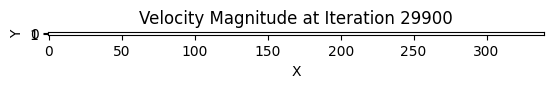

In [14]:
vel = inivel(uLB, ly, 2, nx, ny)
feq = cp.zeros((9, nx, ny))

threadsperblock = (16, 16)
blockspergrid_x = (nx + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (ny + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

equilibrium[blockspergrid, threadsperblock](feq, 1, vel, v, t)

time_stepping(feq, maxIter, nx, ny, obstacle, vel, v, t, omega)